In [3]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Thu Aug 17 14:50:35 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.199.02   Driver Version: 470.199.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   31C    P0    64W / 300W |   6892MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Hyperparams

In [5]:
n_mels = 80
n_outputs = 61
n_frames = 400

In [6]:
from model.model_ecapa_transformer_reg import Model
from utils.util import *
from tensorboardX import SummaryWriter

step = 0
device = 'cuda:0'

# Model
model = Model(in_dim=n_mels, h_dim=512, out_dim=n_outputs)
model = model.to(device)
model.eval()
print('done')

done


In [2]:
!ls -lt /data/scpark/save/lips/train08.16-1/

ls: cannot access '/data/scpark/save/lips/train08.16-1/': No such file or directory


In [8]:
path = '/data/scpark/save/lips/train08.16-1/save_30000'
checkpoint = torch.load(path, map_location=torch.device('cpu'))    
model.load_state_dict(checkpoint['model_state_dict'], strict=True)
print('done')

done


In [9]:
!ls -lS /Storage/speech/tts/kaist-audio-book/wav/남1_동화1/

total 732912
-rw-r--r-- 1 guhyun guhyun 1277038  5월 11 19:49 141.spec.pt
-rwxrwxrwx 1 scpark scpark 1199818 11월 13  2019 1181.wav
-rwxrwxrwx 1 scpark scpark 1158070 11월 13  2019 1449.wav
-rw-r--r-- 1 guhyun guhyun 1086254  5월 11 19:49 232.spec.pt
-rw-r--r-- 1 guhyun guhyun 1065710  5월 11 19:49 231.spec.pt
-rw-r--r-- 1 guhyun guhyun  983598  5월 11 19:48 763.spec.pt
-rw-r--r-- 1 guhyun guhyun  971310  5월 11 19:49 140.spec.pt
-rw-r--r-- 1 guhyun guhyun  954929  5월 11 19:48 1801.spec.pt
-rw-r--r-- 1 guhyun guhyun  944625  5월 11 19:48 1512.spec.pt
-rw-r--r-- 1 guhyun guhyun  944625  5월 11 19:33 1805.spec.pt
-rw-r--r-- 1 guhyun guhyun  928238  5월 11 19:48 868.spec.pt
-rw-r--r-- 1 guhyun guhyun  920049  5월 11 19:48 1433.spec.pt
-rw-r--r-- 1 guhyun guhyun  920049  5월 11 19:48 2007.spec.pt
-rw-r--r-- 1 guhyun guhyun  917937  5월 11 19:33 1036.spec.pt
-rw-r--r-- 1 guhyun guhyun  917934  5월 11 19:33 257.spec.pt
-rw-r--r-- 1 guhyun guhyun  913841  5월 11 19:48 1098.spec.pt
-rwxrwxrwx 1 scpark scpark

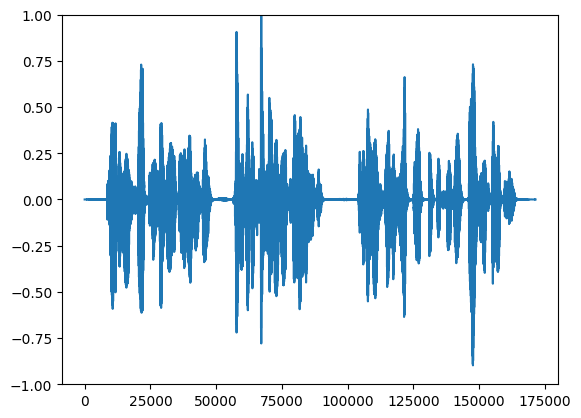

In [10]:
import matplotlib.pyplot as plt
#wav_file = '/Storage/speech/tts/kaist-audio-book/wav/남1_동화1/1181.wav'
wav_file = '/Storage/speech/tts/kaist-audio-book/wav/여1_동화1/1181.wav'
wav, _ = librosa.load(wav_file, sr=16000, res_type='polyphase')
wav = wav / max(abs(wav))

plt.plot(wav)
plt.ylim([-1, 1])
plt.show()

In [11]:
from functools import partial
from data.audio import mel_spectrogram
get_mel = partial(mel_spectrogram, n_fft=2048, num_mels=80, sampling_rate=24000, hop_size=800, win_size=2048, fmin=0, fmax=None, center=False, return_spec=False)
    
def get_blendshape(wav, speaker):
    mel = get_mel(torch.Tensor(wav).unsqueeze(0)).to(device)
    speaker = torch.Tensor(speaker).unsqueeze(0).to(device)
    with torch.no_grad():
        y = model.inference(mel, speaker)
    y = y[0].data.cpu().numpy()
    return mel[0].data.cpu().numpy(), y
    

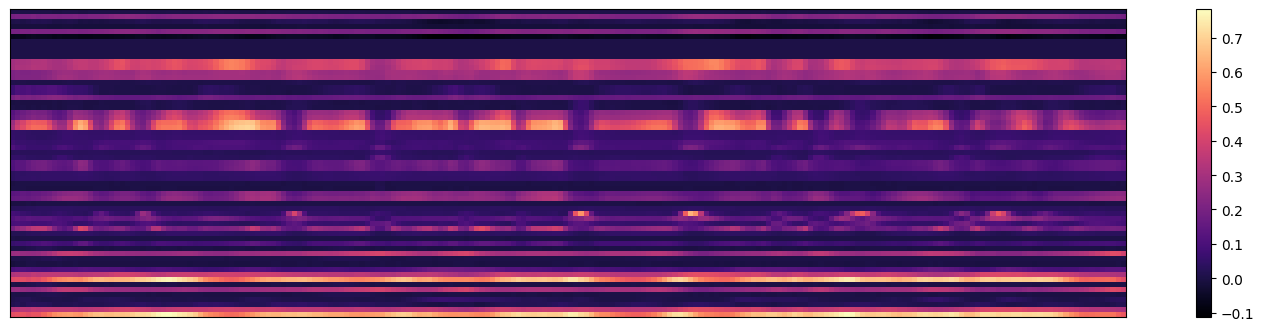

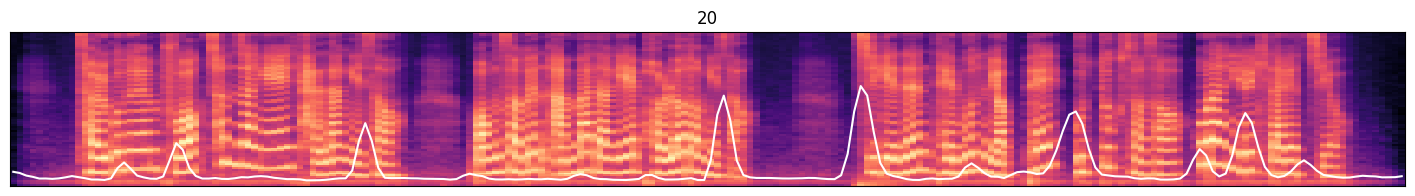

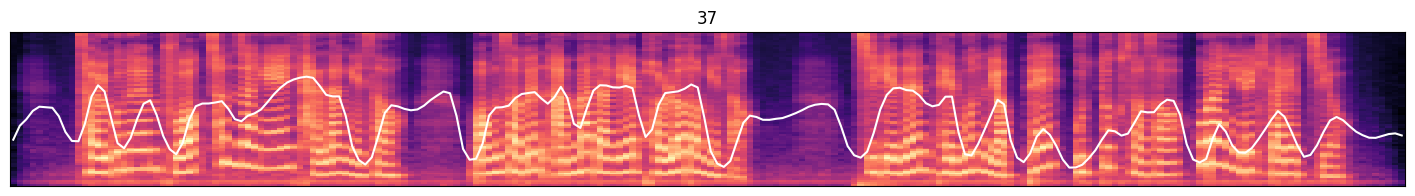

In [12]:
speaker = np.array([-5.0, 0.0])
mel, y = get_blendshape(wav, speaker)
    
import matplotlib.pyplot as plt
import librosa.display

plt.figure(figsize=[18, 4])
librosa.display.specshow(y, cmap='magma')
plt.colorbar()
plt.show()

for i in [20, 37]:
    plt.figure(figsize=[18, 2])
    plt.title(str(i))
    librosa.display.specshow(mel, cmap='magma')
    plt.plot(y[i] * 80, color='white')
    plt.show()


### dataset

In [13]:
from functools import partial
from data.audio import mel_spectrogram
get_mel = partial(mel_spectrogram, n_fft=2048, num_mels=80, sampling_rate=24000, hop_size=800, win_size=2048, fmin=0, fmax=None, center=False, return_spec=False)
print('done')

done


In [14]:
from data.arkit_dataset import LipsDataset

npy_files = ['/data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_1_iPhone_raw.npy',
             '/data/speech/digital_human/preprocessed/jinwooOh/MH_ARKit_005_1_iPhone_raw.npy',
             '/data/speech/digital_human/preprocessed/kyuchulLee/MH_ARKit_006_1_iPhone_raw.npy',
             '/data/speech/digital_human/preprocessed/kyuseokKim/MH_ARKit_002_1_iPhone_raw.npy',
             '/data/speech/digital_human/preprocessed/nohsikPark/MH_ARKit_010_1_iPhone_raw.npy',
             '/data/speech/digital_human/preprocessed/soochulPark/MH_ARKit_004_1_iPhone_raw.npy',
             '/data/speech/digital_human/preprocessed/yehunHwang/MH_ARKit_001_1_iPhone_raw.npy']

datasets = []
for i, npy_file in enumerate(npy_files):
    print(npy_file)
    dataset = LipsDataset(npy_file, n_mels, n_frames, sid=0, mel=False)
    datasets.append(dataset)
    
len(datasets)

/data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_1_iPhone_raw.npy
/data/speech/digital_human/preprocessed/jinwooOh/MH_ARKit_005_1_iPhone_raw.npy
/data/speech/digital_human/preprocessed/kyuchulLee/MH_ARKit_006_1_iPhone_raw.npy
/data/speech/digital_human/preprocessed/kyuseokKim/MH_ARKit_002_1_iPhone_raw.npy
/data/speech/digital_human/preprocessed/nohsikPark/MH_ARKit_010_1_iPhone_raw.npy
/data/speech/digital_human/preprocessed/soochulPark/MH_ARKit_004_1_iPhone_raw.npy
/data/speech/digital_human/preprocessed/yehunHwang/MH_ARKit_001_1_iPhone_raw.npy


7

In [15]:
n_samples = 30
inputs = []
targets = []
tags = []
for i, dataset in enumerate(datasets):
    print(i)
    for j in range(n_samples):
        data_index = np.random.randint(0, len(dataset))
        data = dataset[data_index]
        wav = torch.Tensor(data['wav']).unsqueeze(0)
        input = get_mel(wav)
        inputs.append(input)
        target = torch.Tensor(data['blend'])
        targets.append(target)
    
inputs = torch.cat(inputs, dim=0).to(device)
targets = torch.stack(targets, dim=0).transpose(1, 2).to(device)
print(inputs.shape, targets.shape)

0
1
2
3
4
5
6
torch.Size([210, 80, 400]) torch.Size([210, 61, 400])


In [16]:
model.eval()
with torch.no_grad():
    outputs = model(inputs, targets)

print(outputs['speaker'].shape)

torch.Size([210, 2])


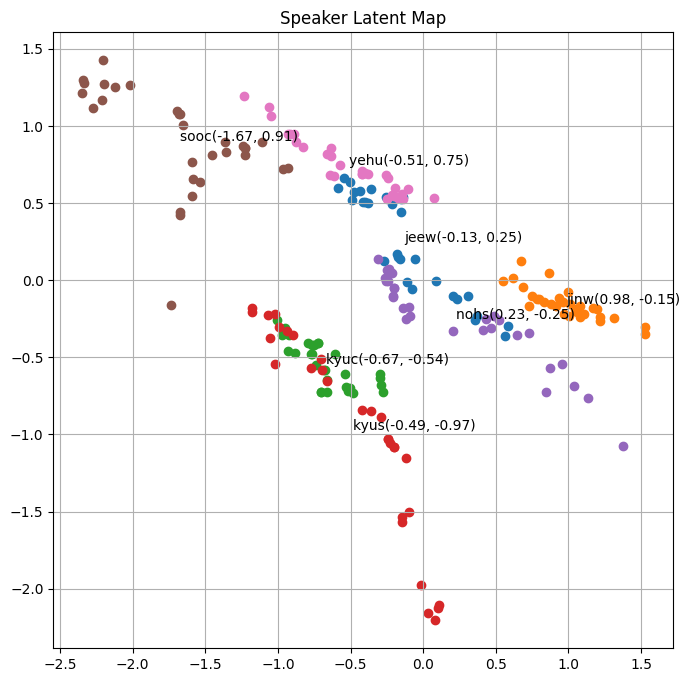

In [18]:
speaker = outputs['speaker'].data.cpu().numpy()

import matplotlib.pyplot as plt

names = ['jeewonPark', 'jinwooOh', 'kyuchulLee', 'kyuseokKim', 'nohsikPark', 'soochulPark', 'yehunHwang']
plt.figure(figsize=[8, 8])
plt.title('Speaker Latent Map')
for i in range(7):
    plt.scatter(speaker[i*n_samples:(i+1)*n_samples, 0], speaker[i*n_samples:(i+1)*n_samples, 1])
    mean = np.mean(speaker[i*n_samples:(i+1)*n_samples], axis=0)
    plt.text(mean[0], mean[1], names[i][:4] + "({:.2f}, {:.2f})".format(mean[0], mean[1]))
plt.grid()
plt.show()